In [32]:
from utilities.setup_environment import *
from utilities.utilities import *
from utilities.plotting import *
from utilities.getStim import *
pd.set_option('display.max_columns', None)

import matplotlib.cm as cm
import matplotlib.colors as mcolors
from mpl_toolkits.axes_grid1 import make_axes_locatable
sns.set_context("poster")
from scipy.stats import sem
import os

In [33]:
df = pd.read_hdf('Data/TemporalNoise1f_v2.h5', key='data')
print(df['cell_type'].unique())
cell_type ='OFF transient alpha'
cell_text = True

['OFF transient alpha' 'ON alpha' 'ON delayed' 'OFF sustained alpha']


In [34]:
psd_df = df.apply(lambda row: compute_psd_stats(row, fs=row['frame_rate']), axis=1)
results_all = pd.concat([df.reset_index(drop=True), psd_df], axis=1)
ctype_df = results_all.query(f"cell_type == '{cell_type}'").copy().reset_index(drop=True)
freqs = ctype_df['freqs'].iloc[0]
frame_rate = ctype_df['frame_rate'].iloc[0]


In [35]:

cell_results = []

for cell_name in ctype_df['cell_name'].unique():
    cell_df = ctype_df[ctype_df['cell_name'] == cell_name]
    for beta_value in sorted(cell_df['beta'].unique()):
        data_for_beta = cell_df[cell_df['beta'] == beta_value]

        stim_psd = np.mean(np.stack(data_for_beta['Pxx_stim']), axis=0)
        rs_spikes_psd = np.mean(np.stack(data_for_beta[data_for_beta['noise_seed'] == 1]['Pxx_spikes']), axis=0)
        nr_spikes_psd = np.mean(np.stack(data_for_beta[data_for_beta['noise_seed'] != 1]['Pxx_spikes']), axis=0)
        H_f_power_rs = np.mean(np.stack(data_for_beta[data_for_beta['noise_seed'] == 1]['H_f_pxx']), axis=0)
        H_f_power_nr = np.mean(np.stack(data_for_beta[data_for_beta['noise_seed'] != 1]['H_f_pxx']), axis=0)

        cell_results.append({
            'cell_type': data_for_beta['cell_type'].iloc[0],
            'cell_name': cell_name,
            'freq': freqs,
            'beta': beta_value,
            'stim_psd': stim_psd,
            'rs_spikes_psd': rs_spikes_psd,
            'nr_spikes_psd': nr_spikes_psd,
            'H_f_power_rs': H_f_power_rs,
            'H_f_power_nr': H_f_power_nr
        })

df_celltype = pd.DataFrame(cell_results)
print(df_celltype['cell_name'].unique())

['032525Bc5' '040325Bc8' '052325Bc2']


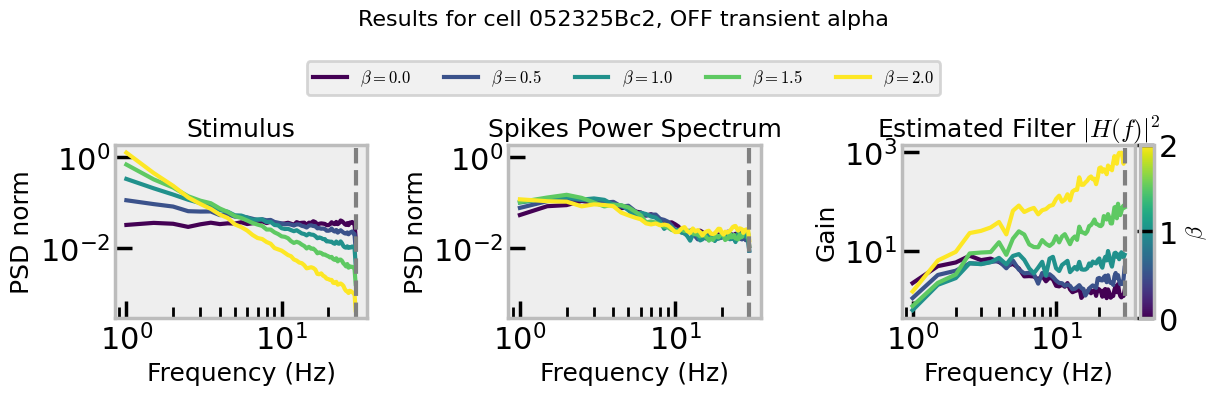

In [36]:
cell_name = '052325Bc2'
if cell_name in df_celltype['cell_name'].unique():
    fig = plot_example_cell(cell_name, df_celltype)

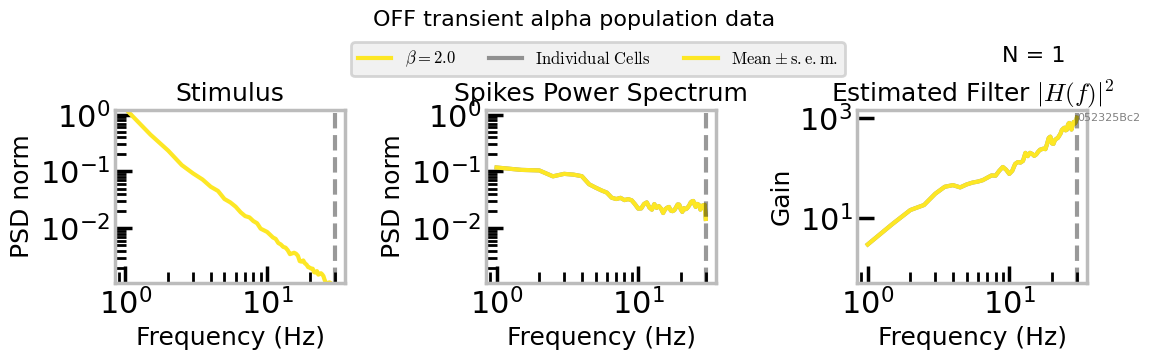

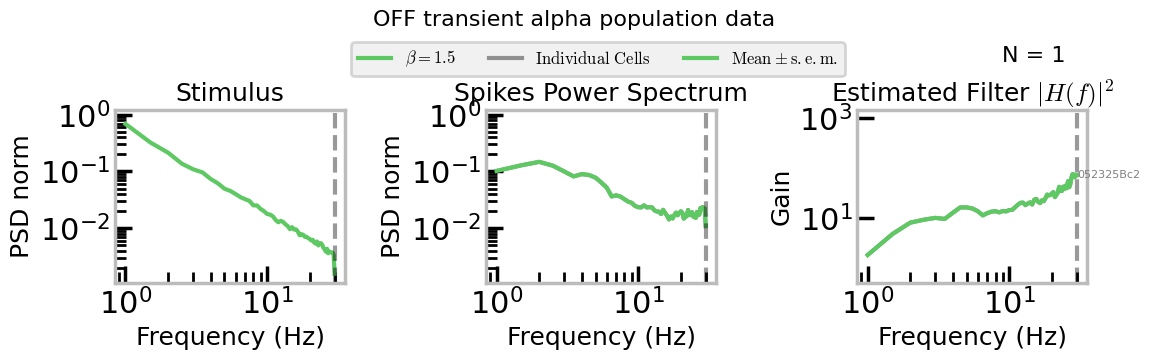

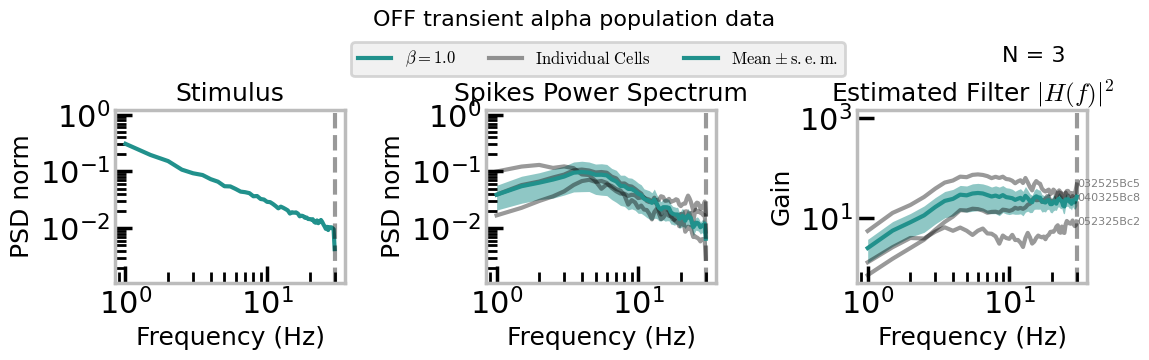

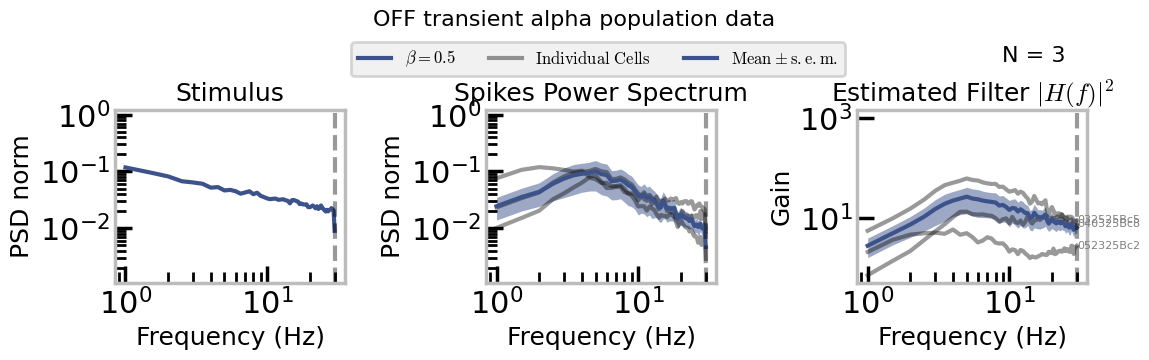

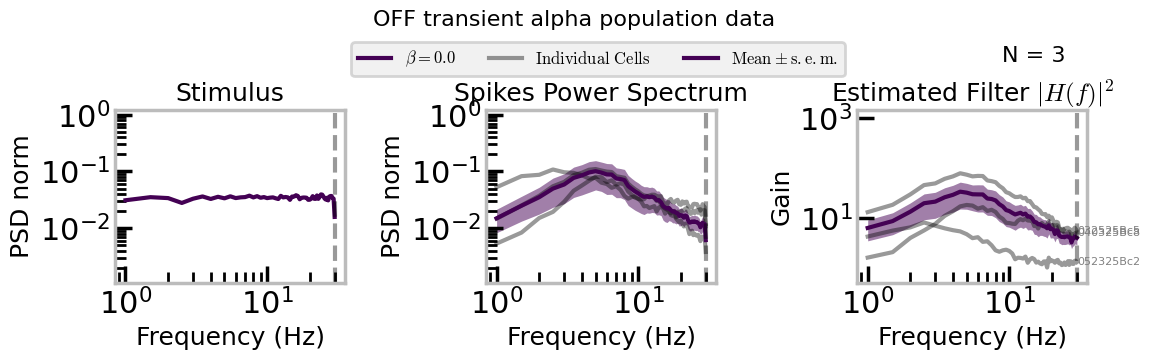

In [37]:
# Precompute global y-axis limits
all_nr_psd = []
all_gain = []

for beta_value in df_celltype['beta'].unique():
    data_beta = df_celltype[df_celltype['beta'] == beta_value]
    nr_psd_stack = np.stack(data_beta['nr_spikes_psd'].values)[:, 1:]
    gain_stack = np.stack(data_beta['H_f_power_nr'].values)[:, 1:]

    all_nr_psd.append(nr_psd_stack)
    all_gain.append(gain_stack)

all_nr_psd = np.concatenate(all_nr_psd, axis=0)
all_gain = np.concatenate(all_gain, axis=0)

# Normalize PSDs
norm_factors = np.trapz(all_nr_psd, axis=1)
norm_nr_psd = all_nr_psd / norm_factors[:, None]

min_psd = np.min(norm_nr_psd[norm_nr_psd > 0])
max_psd = np.max(norm_nr_psd)
min_gain = np.min(all_gain[all_gain > 0])
max_gain = np.max(all_gain)

psd_pad = (np.log10(max_psd) - np.log10(min_psd)) * 0.05
gain_pad = (np.log10(max_gain) - np.log10(min_gain)) * 0.05
if max_psd < 1:
    max_psd = 1

if min_psd < 1e-3:
    min_psd = 1e-3
psd_ylim = (10**(np.log10(min_psd) - psd_pad), 10**(np.log10(max_psd) + psd_pad))
gain_ylim = (10**(np.log10(min_gain) - gain_pad), 10**(np.log10(max_gain) + gain_pad))

beta_values = sorted(df_celltype['beta'].unique())
norm = mcolors.Normalize(vmin=min(beta_values), vmax=max(beta_values))
cmap = plt.get_cmap('viridis')
label_fontsize = 18
for beta_value in reversed(beta_values):
    color = cmap(norm(beta_value))
    data_beta = df_celltype[df_celltype['beta'] == beta_value]
    n_cells = data_beta['cell_name'].nunique()
    freqs = df_celltype[df_celltype['beta'] == beta_value]['freq'].iloc[0]
    stim_psd = df_celltype[df_celltype['beta'] == beta_value]['stim_psd'].iloc[0]
    
    nr_psd_stack = np.stack(data_beta['nr_spikes_psd'].values)
    gain_stack = np.stack(data_beta['H_f_power_nr'].values)

    # Compute mean & SEM (excluding DC)
    mean_nr_spikes_psd = np.mean(nr_psd_stack[:, 1:], axis=0)
    sem_nr_spikes_psd = np.std(nr_psd_stack[:, 1:], axis=0) / np.sqrt(n_cells)

    mean_gain = np.mean(gain_stack[:, 1:], axis=0)
    sem_gain = np.std(gain_stack[:, 1:], axis=0) / np.sqrt(n_cells)

    # Normalize mean spike PSD and SEM
    norm_factor = np.trapz(mean_nr_spikes_psd, freqs[1:])
    mean_nr_spikes_psd /= norm_factor
    sem_nr_spikes_psd /= norm_factor
    
    fig, axes = plt.subplots(1, 3, figsize=(12, 4), sharey=False)
    fig.suptitle(f"{cell_type} population data", fontsize=16, y=.94)
    fig.text(0.91, 0.85, f"N = {n_cells}", ha='right', va='top', fontsize=16)

    for i, cell_name in enumerate(data_beta['cell_name'].unique()):
        label_cell = r'$\mathrm{Individual \ Cells}$' if i == 0 else None
        row = data_beta[data_beta['cell_name'] == cell_name].iloc[0]
        nr_spikes_psd = row['nr_spikes_psd']
        H_f_power_nr = row['H_f_power_nr']

    
        axes[1].loglog(freqs[1:], nr_spikes_psd[1:] / np.trapz(nr_spikes_psd[1:], freqs[1:]),
                    alpha=0.4, c='k', label=label_cell)

    
        axes[2].loglog(freqs[1:], H_f_power_nr[1:], alpha=0.4, c='k')
        if cell_text:
            axes[2].text(freqs[-1], H_f_power_nr[-1], cell_name, fontsize=8, color='gray', ha='left', va='center')
    axes[0].loglog(freqs[1:], stim_psd[1:] / np.trapz(stim_psd[1:], freqs[1:]),
                   label=fr"$\beta={beta_value}$", c=color)

    axes[1].loglog(freqs[1:], mean_nr_spikes_psd, label=fr"$\mathrm{{Mean}} \pm \mathrm{{s.e.m.}}$", color=color)
    axes[1].fill_between(freqs[1:], 
                         mean_nr_spikes_psd - sem_nr_spikes_psd,
                         mean_nr_spikes_psd + sem_nr_spikes_psd,
                         color=color, alpha=0.5, linewidth=0)

    axes[2].loglog(freqs[1:], mean_gain, label=fr"$\beta={beta_value}$", color=color)
    axes[2].fill_between(freqs[1:], 
                         mean_gain - sem_gain,
                         mean_gain + sem_gain,
                         color=color, alpha=0.5, linewidth=0)
    titles = ["Stimulus", "Spikes Power Spectrum", r"Estimated Filter $|H(f)|^2$"]
    ylabels = ["PSD norm", "PSD norm", "Gain"]
    fig.patch.set_facecolor('white')     
    for i, ax in enumerate(axes):
        ax.set_facecolor('white')  
        ax.set_title(titles[i], fontsize=label_fontsize)
        ax.set_xlabel("Frequency (Hz)", fontsize=label_fontsize)
        ax.set_ylabel(ylabels[i], fontsize=label_fontsize)
        ax.axvline(frame_rate / 2, color='k', alpha=0.4, linestyle='--')
        ax.grid(visible=False)
        ax.set_ylim(psd_ylim if i != 2 else gain_ylim)
        

    handles0, labels0 = axes[0].get_legend_handles_labels()
    handles1, labels1 = axes[1].get_legend_handles_labels()
    unique_labels = dict(zip(labels0 + labels1, handles0 + handles1))
    fig.legend(unique_labels.values(), unique_labels.keys(),
               loc='upper center', bbox_to_anchor=(0.52, 0.88), ncol=4, fontsize=12)

    plt.tight_layout()
    plt.show()

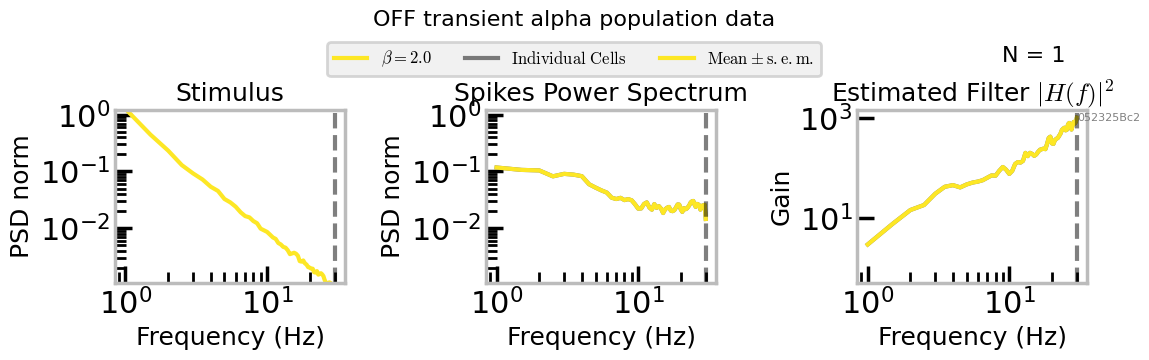

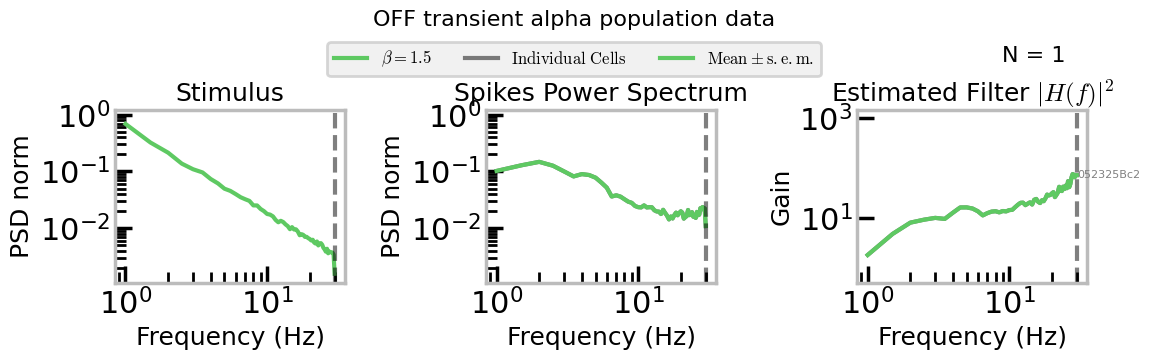

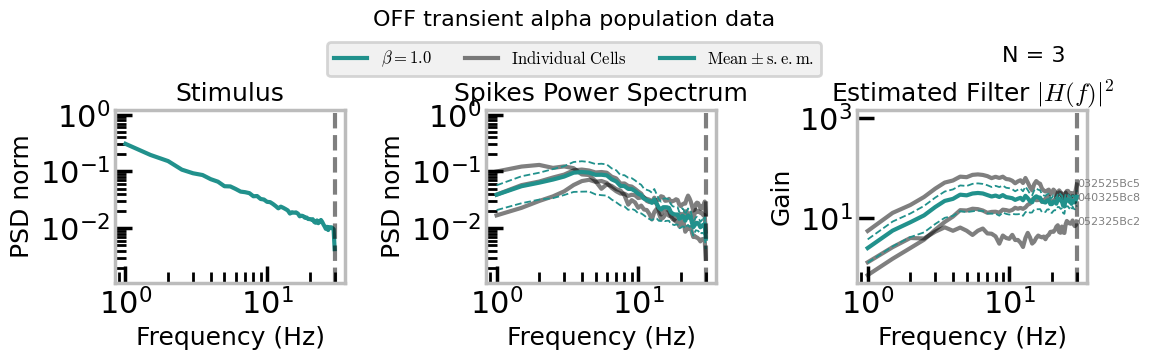

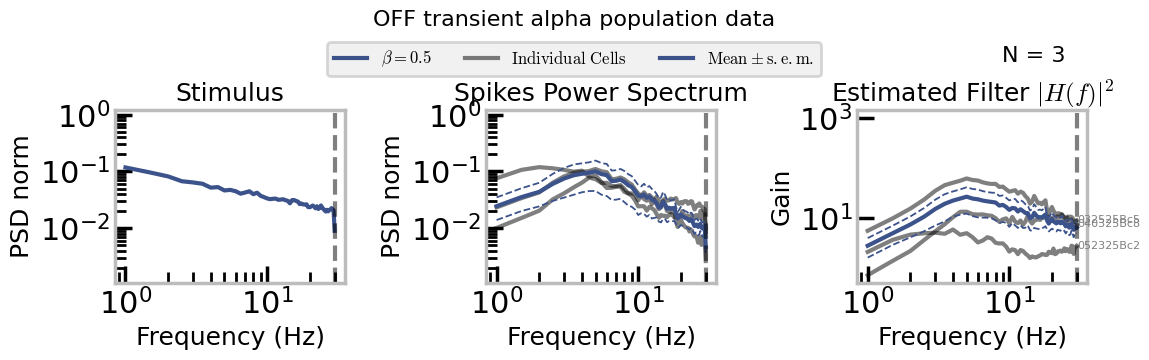

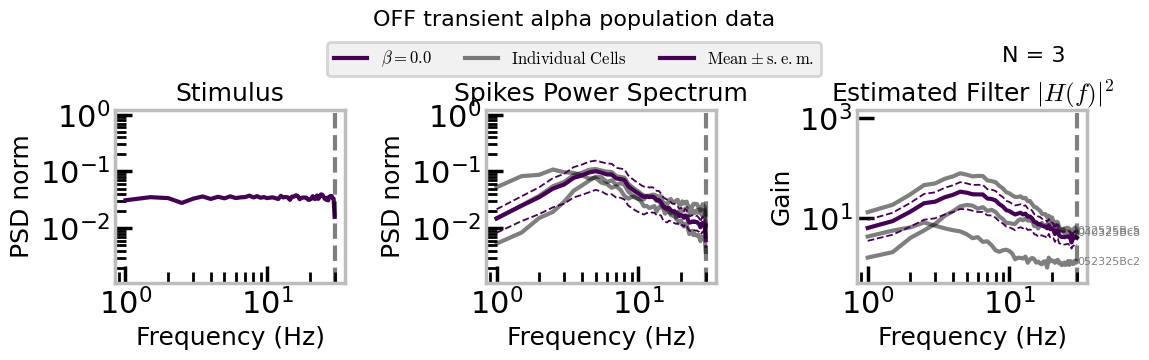

In [38]:
# Precompute global y-axis limits
all_nr_psd = []
all_gain = []

for beta_value in df_celltype['beta'].unique():
    data_beta = df_celltype[df_celltype['beta'] == beta_value]
    nr_psd_stack = np.stack(data_beta['nr_spikes_psd'].values)[:, 1:]
    gain_stack = np.stack(data_beta['H_f_power_nr'].values)[:, 1:]

    all_nr_psd.append(nr_psd_stack)
    all_gain.append(gain_stack)

all_nr_psd = np.concatenate(all_nr_psd, axis=0)
all_gain = np.concatenate(all_gain, axis=0)

# Normalize PSDs
norm_factors = np.trapz(all_nr_psd, axis=1)
norm_nr_psd = all_nr_psd / norm_factors[:, None]

# Calculate log-safe min/max for consistent ylim
min_psd = np.min(norm_nr_psd[norm_nr_psd > 0])
max_psd = np.max(norm_nr_psd)
min_gain = np.min(all_gain[all_gain > 0])
max_gain = np.max(all_gain)

psd_pad = (np.log10(max_psd) - np.log10(min_psd)) * 0.05
gain_pad = (np.log10(max_gain) - np.log10(min_gain)) * 0.05
if max_psd < 1:
    max_psd = 1
if min_psd < 1e-3:
    min_psd = 1e-3
psd_ylim = (10**(np.log10(min_psd) - psd_pad), 10**(np.log10(max_psd) + psd_pad))
gain_ylim = (10**(np.log10(min_gain) - gain_pad), 10**(np.log10(max_gain) + gain_pad))

# Define beta colormap
beta_values = sorted(df_celltype['beta'].unique())
norm = mcolors.Normalize(vmin=min(beta_values), vmax=max(beta_values))
cmap = plt.get_cmap('viridis')
label_fontsize = 18

for beta_value in reversed(beta_values):
    color = cmap(norm(beta_value))
    data_beta = df_celltype[df_celltype['beta'] == beta_value]
    n_cells = data_beta['cell_name'].nunique()
    freqs = data_beta['freq'].iloc[0]
    stim_psd = data_beta['stim_psd'].iloc[0]

    nr_psd_stack = np.stack(data_beta['nr_spikes_psd'].values)
    gain_stack = np.stack(data_beta['H_f_power_nr'].values)

    mean_nr_spikes_psd = np.mean(nr_psd_stack[:, 1:], axis=0)
    sem_nr_spikes_psd = np.std(nr_psd_stack[:, 1:], axis=0) / np.sqrt(n_cells)
    mean_gain = np.mean(gain_stack[:, 1:], axis=0)
    sem_gain = np.std(gain_stack[:, 1:], axis=0) / np.sqrt(n_cells)

    norm_factor = np.trapz(mean_nr_spikes_psd, freqs[1:])
    mean_nr_spikes_psd /= norm_factor
    sem_nr_spikes_psd /= norm_factor

    fig, axes = plt.subplots(1, 3, figsize=(12, 4), sharey=False)
    fig.suptitle(f"{cell_type} population data", fontsize=16, y=.94)
    fig.text(0.91, 0.85, f"N = {n_cells}", ha='right', va='top', fontsize=16)
    fig.patch.set_facecolor('white')
    for ax in axes:
        ax.set_facecolor('white')

    for i, cell_name in enumerate(data_beta['cell_name'].unique()):
        label_cell = r'$\mathrm{Individual\ Cells}$' if i == 0 else None
        row = data_beta[data_beta['cell_name'] == cell_name].iloc[0]
        nr_spikes_psd = row['nr_spikes_psd']
        H_f_power_nr = row['H_f_power_nr']

        axes[1].loglog(freqs[1:], nr_spikes_psd[1:] / np.trapz(nr_spikes_psd[1:], freqs[1:]),
                       alpha=0.5, c='k', label=label_cell)
        axes[2].loglog(freqs[1:], H_f_power_nr[1:], alpha=0.5, c='k')
        if cell_text:
            axes[2].text(freqs[-1], H_f_power_nr[-1], cell_name, fontsize=8, color='gray', ha='left', va='center')

    axes[0].loglog(freqs[1:], stim_psd[1:] / np.trapz(stim_psd[1:], freqs[1:]),
                   label=fr"$\beta={beta_value}$", c=color)
    axes[1].loglog(freqs[1:], mean_nr_spikes_psd, label=fr"$\mathrm{{Mean}} \pm \mathrm{{s.e.m.}}$", color=color)
    axes[1].loglog(freqs[1:], mean_nr_spikes_psd + sem_nr_spikes_psd, linestyle='--', linewidth=1.3, color=color)
    axes[1].loglog(freqs[1:], mean_nr_spikes_psd - sem_nr_spikes_psd, linestyle='--', linewidth=1.3, color=color)

    axes[2].loglog(freqs[1:], mean_gain, label=fr"$\beta={beta_value}$", color=color)
    axes[2].loglog(freqs[1:], mean_gain + sem_gain, linestyle='--', linewidth=1.3, color=color)
    axes[2].loglog(freqs[1:], mean_gain - sem_gain, linestyle='--', linewidth=1.3, color=color)

    titles = ["Stimulus", "Spikes Power Spectrum", r"Estimated Filter $|H(f)|^2$"]
    ylabels = ["PSD norm", "PSD norm", "Gain"]
    for i, ax in enumerate(axes):
        ax.set_title(titles[i], fontsize=label_fontsize)
        ax.set_xlabel("Frequency (Hz)", fontsize=label_fontsize)
        ax.set_ylabel(ylabels[i], fontsize=label_fontsize)
        ax.axvline(frame_rate / 2, color='k', alpha=0.5, linestyle='--')
        ax.grid(False)
        ax.set_ylim(psd_ylim if i != 2 else gain_ylim)

    handles0, labels0 = axes[0].get_legend_handles_labels()
    handles1, labels1 = axes[1].get_legend_handles_labels()
    unique_labels = dict(zip(labels0 + labels1, handles0 + handles1))
    fig.legend(unique_labels.values(), unique_labels.keys(),
               loc='upper center', bbox_to_anchor=(0.5, 0.88), ncol=4, fontsize=12)

    plt.tight_layout()
    plt.show()
